# Evaluate agent performance across runs in an experiment

Using the [MLflow tracking API](https://www.mlflow.org/docs/latest/tracking.html).

In [1]:
%config Completer.use_jedi = False
import os
from pathlib import Path
from typing import Sequence
import json

import pandas as pd
import numpy as np
from scipy.stats import dirichlet, gamma

import mlflow

import matplotlib.pyplot as plt

from clovek_ne_jezi_se.agents import FurthestAlongPlayer, RandomPlayer
from clovek_ne_jezi_se.run_experiments import get_experiment_variables_from_config_dir

## Helper functions

E.g. convert run parameter dictionary into disjuntive ("and") filter query string, to be used with [mlflow.search_runs](https://mlflow.org/docs/latest/python_api/mlflow.html#mlflow.search_runs).

TODO read in from json parameter file, rather than copy pasting dict from script?

In [2]:
def dict_to_conjunctive_filter_equality_string(a_dict, tracking_type: str):
    """
    Convert a dictionary of a given tracking type--params, metrics, tags--
    to a conjunctive (i.e. 'and') filter string of equality conditions.
    
    Lists are converted to comma-separated strings.
    """
    conditions = []
    for key, value in a_dict.items():
        if isinstance(value, list):
            value = ','.join(value)
        conditions.append(tracking_type + '.' + key + '="' + str(value) + '"')
    return " and ".join(conditions)
        
    return (
        "params.agents = 'RandomPlayer,RandomPlayer,RandomPlayer,RandomPlayer'"
        " and params.main_board_section_length = 1"
    )


def get_int_value_counts_from_floats(series_of_floats: pd.Series) -> pd.Series:
    counts = series_of_floats.value_counts(dropna=True)
    # Convert index to ints
    counts.index = counts.index.astype(int)
    return counts

def average_by_series_index_type(series: pd.Series, index_type_values: Sequence, type_name: str) -> pd.Series:
    """
    Map index to index type values, and then average according to these values.
    
    The use case in mind is player win counts, which include the player order, but averaging
    along the agent type of each player.
    """
    index_sorted_series = series.sort_index()
    res = index_sorted_series.to_frame()
    res[type_name] = index_type_values
    res = res.groupby(type_name).mean()
    res = res.squeeze()
    res.name = series.name
    
    return res
    
    
    return pd.Series(data=[10,5], index=['oy', 'yadda'])


# Tests

def test_dict_to_conjunctive_filter_equality_string():
    player_names = ['red', 'blue', 'green', 'yellow']
    players = [RandomPlayer(name=name, print_game_state=False) for name in player_names]

    main_board_section_length = 1
    agents = [player.__class__.__name__ for player in players]

    run_params = dict(
        agents=','.join(agents),
        main_board_section_length=main_board_section_length
    )
    
    filter_string = dict_to_conjunctive_filter_equality_string(run_params, tracking_type='params')
    expected = (
        'params.agents="RandomPlayer,RandomPlayer,RandomPlayer,RandomPlayer"'
        ' and params.main_board_section_length="1"'
    )
    try:
        assert filter_string == expected
    except AssertionError as err:
        print(err, filter_string, ' is not ', expected)


def test_get_int_value_counts_from_floats():
    series = pd.Series([np.nan, 3.0, 0.0, 0.0])
    expected = pd.Series(data=[2, 1], index=[0, 3])
    res = get_int_value_counts_from_floats(series)
    pd.testing.assert_series_equal(res, expected)
    

def test_average_by_series_index_type():
    index_type_values = ['yadda', 'yadda', 'oy']
    series = pd.Series(data=[10, 2, 4], index=[2,0,1], name='yiddish-counts')
    type_name = 'agent'
    
    res = average_by_series_index_type(series, index_type_values, type_name=type_name)
    expected = pd.Series(data=[10,3], index=['oy', 'yadda'], name='yiddish-counts')
    expected.index.name = type_name
    
    pd.testing.assert_series_equal(res, expected)
        
test_dict_to_conjunctive_filter_equality_string()
test_get_int_value_counts_from_floats()
test_average_by_series_index_type()

## Get winner counts

First we define a filter query string, then use [mlflow.search_runs](https://mlflow.org/docs/latest/python_api/mlflow.html#mlflow.search_runs) to get run results as a pandas dataframe.

In [3]:
experiment_name = 'player-order'
config_dir = Path(os.environ['EXPERIMENT_CONFIGS_DIR']) / experiment_name
configs = []
for f in config_dir.iterdir():
    with open(f, 'r') as fp: 
        configs.append(json.load(fp))
configs

[{'players': [{'name': '0',
    'agent': 'RandomPlayer',
    'kwargs': {'print_game_state': False}},
   {'name': '1',
    'agent': 'RandomPlayer',
    'kwargs': {'print_game_state': False}},
   {'name': '2',
    'agent': 'RandomPlayer',
    'kwargs': {'print_game_state': False}},
   {'name': '3',
    'agent': 'RandomPlayer',
    'kwargs': {'print_game_state': False}}],
  'board': {'main_board_section_length': 4,
   'pieces_per_player': 4,
   'number_of_dice_faces': 6},
  'n_runs': 500}]

In [4]:
# Pick configuration values for experiment run filtering
player_names = [str(n) for n in range(4)]
agents = len(player_names) * ['RandomPlayer']
run_params = dict(
    agents=','.join(agents),
    main_board_section_length=4,
    pieces_per_player=4,
    number_of_dice_faces=6,
)
filter_string = dict_to_conjunctive_filter_equality_string(run_params, 'params')
# mlflow tracking api stuff seemingly must be run from parent directory of mlruns
os.chdir(os.environ['RUNS_PARENT_DIR'])
experiment_id = mlflow.get_experiment_by_name(experiment_name).experiment_id
#experiment_id = '1'
runs = mlflow.search_runs([experiment_id], filter_string=filter_string)

Winner counts
 0    257
2    257
3    248
1    238
Name: metrics.winner_idx, dtype: int64


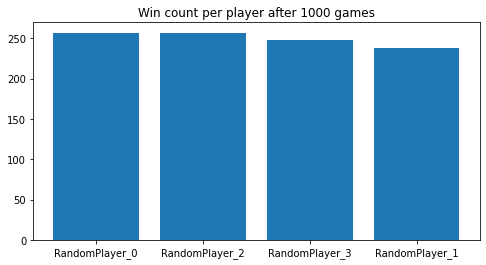

In [5]:
winner_counts = get_int_value_counts_from_floats(runs['metrics.winner_idx'])
names_with_play_order = [agents[idx] + '_' + str(idx) for idx in winner_counts.index]
counts = winner_counts.values
print('Winner counts\n', winner_counts)

# Plot
fig, ax = plt.subplots(figsize=(8, 4))
#top, bottom = ax
ax.bar(names_with_play_order, counts)
ax.set_title(f'Win count per player after {winner_counts.sum()} games');

## Experiment analysis

It seems likely that player order does not matter for $K=4$ random players on a small board after $N=1000$ rounds of play, but let's quantify this, as in Bishop's [Pattern Recognition and Machine Learning](https://www.springer.com/de/book/9780387310732) 2.2.

The winner counts can be modeled as a [multinomial random variable](https://en.wikipedia.org/wiki/Multinomial_distribution) $M = (m_0, m_1, m_2, m_3)$ with probability distribution

$$P(M = m) = \frac{(\sum m_k)!}{\prod m_k!} \mu_i^{m_k},$$

where $p_i$ is the probability of player $k$ winning a game, so that $\sum \mu_k = 1$.

The statement that player order does not matter reduces to $\mu_k = 0.25$ for $k=0, \ldots, 3$.

We can estimate how likely the parameter setting $p_k = 0.25$ is using a Bayesian approach. The common prior for the multinomial is the [Dirichlet distribution](https://en.wikipedia.org/wiki/Dirichlet_distribution),

$$P(m | \alpha) = \frac{\Gamma\left(\sum \alpha_k\right)}{\Gamma(\alpha_0) \cdot \ldots \cdot \Gamma(\alpha_3)} \prod \mu_i^{\alpha_k - 1},$$

where $\Gamma(\alpha)$ is the [Gamma function](https://en.wikipedia.org/wiki/Gamma_function).

Hence the probability of $\mu_0 = \ldots = \mu_3 = 0.25$ is given by subsituting the win-counts $m_0, \ldots, m_3$ into

$$P(\mu | D, \alpha) = \frac{\Gamma\left(\sum \alpha_k + N \right)}{\Gamma(\alpha_0 + m_0) \ldots \Gamma(\alpha_3 + m_3) } \prod_{k=0}^3 \mu_k^{\alpha_k + m_k - 1}$$

In [6]:
m = counts
alpha = np.array(4 * [2.])
null_hypothesis_mu = np.array(4 * [0.25])  # I.e. player order makes no difference.
empirical_mu = winner_counts / winner_counts.sum()
likelihood_ratio = dirichlet.pdf(null_hypothesis_mu, alpha + m) / dirichlet.pdf(empirical_mu, alpha + m)
print(f'Likelihood ratio: {likelihood_ratio}')

Likelihood ratio: 0.6108235961707239
